In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import json
import re
import shap
import lightgbm as lgb
import itertools
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

from utils.utils import *
from utils.pre_processing import *
from utils.nn import *
from utils.nn_utils import *

In [40]:
df = load_data('data/df_tags','data/final_reviews')
X_train, X_test, X_val, y_val, y_train, y_test = init_df(df,test_size=0.2,target_col='target',stratify=True,scaling=True,oversampling=True,undersampling=False)
X_train, X_test, X_val, to_remove = remove_highly_correlated_features(X_train, X_test, X_val, threshold=0.9)
df = df.drop(columns=df.columns[to_remove])

In [41]:
feature_names = df.columns[:-1]  # Assuming the last column is the target

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=list(feature_names))
lgb_val = lgb.Dataset(X_val, label=y_val, feature_name=list(feature_names), reference=lgb_train)

# Define the model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1
}

def f1_eval(y_pred, dataset):
    y_true = dataset.get_label()
    y_pred_binary = np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred_binary), True

# Train the model
model = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=100, 
    valid_sets=[lgb_train, lgb_val], 
    valid_names=['train', 'val'],
    feval=f1_eval
)

# Make predictions on the validation set
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_val_pred_binary = np.round(y_val_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Get feature importance
importance = model.feature_importance()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Return the feature importance and metrics
evaluation_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

quantile_to_keep = 0.5
min_imp = feature_importance['Importance'].quantile(quantile_to_keep)
imp_feats = feature_importance.loc[feature_importance['Importance'] >= min_imp]['Feature']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2705, number of negative: 2705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75579
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 304
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8263305322128851
Precision: 0.1
Recall: 0.17307692307692307
F1 Score: 0.1267605633802817


In [95]:
df = load_data('data/df_tags','data/final_reviews')
X_train, X_test, X_val, y_val, y_train, y_test = init_df(df,test_size=0.2,target_col='target',stratify=True,scaling=True,oversampling=False,undersampling=False)
df = df.drop(columns=df.columns[to_remove])

X_train = np.delete(X_train, to_remove, axis=1)
X_val = np.delete(X_val, to_remove, axis=1)
X_test = np.delete(X_test, to_remove, axis=1)

reduced_X_train = X_train[:, imp_feats.index]
reduced_X_val = X_val[:, imp_feats.index]
reduced_X_test = X_test[:, imp_feats.index]

train_loader, test_dataset, val_dataset = create_datasets(reduced_X_train, y_train, reduced_X_test, y_test, reduced_X_val, y_val, val=True, batch_size=320)

In [96]:
# model_results = pd.read_csv('new_model_results.csv')
# model_results = model_results[[col for col in model_results.columns if 'Unnamed' not in col]]
# model_results = model_results.sort_values('Mean F1',ascending=False).head(3)
# model_results

# model_results = pd.read_csv('new_model_results_undersampling_CV.csv')
# model_results = model_results[[col for col in model_results.columns if 'Unnamed' not in col]]
# model_results = model_results.sort_values('Mean F1',ascending=False).head(3)
# model_results

# model_results = pd.read_csv('new_model_results_pos_weight_CV.csv')
# model_results = model_results[[col for col in model_results.columns if 'Unnamed' not in col]]
# model_results = model_results.sort_values('Mean F1',ascending=False).head(3)
# model_results

In [97]:
#constantes

input_size = reduced_X_train.shape[1]
output_size = 1
hidden_activation = 'relu'
output_activation='sigmoid'
criterion = 'BCEWithLogitsLoss'
device = 'cpu'
pos_weight = (1 - df['target']).sum()/df['target'].sum()

In [98]:
hidden_size = [32]
lr = 0.00001
num_epochs = 1000
patience = 10
momentum = 0
optimizer_name = 'Adam'
pos_weight_factor = 1

model = NeuralNetwork(input_size, hidden_size, output_size, torch.tensor(pos_weight_factor*pos_weight),lr, device=device, hidden_activation=hidden_activation, output_activation=output_activation,criterion=criterion)

In [99]:
train_nn(model, train_loader, val_dataset,optimizer_name=optimizer_name,num_epochs=num_epochs, skip=50,patience=patience,momentum=momentum)
print('Training done')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 1.336 | Val Loss: 1.4869 | Train F1: 0.1240| Val F1: 0.0757
Epoch 100: | Train Loss: 1.334 | Val Loss: 1.4843 | Train F1: 0.1133| Val F1: 0.0941
Epoch 150: | Train Loss: 1.324 | Val Loss: 1.4819 | Train F1: 0.1530| Val F1: 0.1104
Epoch 200: | Train Loss: 1.317 | Val Loss: 1.4800 | Train F1: 0.1716| Val F1: 0.1358
Epoch 250: | Train Loss: 1.311 | Val Loss: 1.4781 | Train F1: 0.1894| Val F1: 0.1410
Epoch 300: | Train Loss: 1.309 | Val Loss: 1.4764 | Train F1: 0.1721| Val F1: 0.1361
Epoch 350: | Train Loss: 1.299 | Val Loss: 1.4750 | Train F1: 0.2079| Val F1: 0.1449
Epoch 400: | Train Loss: 1.297 | Val Loss: 1.4737 | Train F1: 0.1945| Val F1: 0.1240
Epoch 450: | Train Loss: 1.293 | Val Loss: 1.4727 | Train F1: 0.2265| Val F1: 0.1311
Epoch 500: | Train Loss: 1.293 | Val Loss: 1.4718 | Train F1: 0.2243| Val F1: 0.1176
Epoch 550: | Train Loss: 1.283 | Val Loss: 1.4710 | Train F1: 0.2419| Val F1: 0.1197
Epoch 600: | Train Loss: 1.278 | Val Loss: 1.4703 | Train F1: 0.2

In [100]:
print('Val Metrics: ')

y_pred = predict_nn(model,val_dataset)
eval_predict_nn(y_val, y_pred)

print('\nTest Metrics: ')

y_pred = predict_nn(model,test_dataset)
eval_predict_nn(y_test, y_pred)
print('Metrics Done')

Val Metrics: 
Accuracy: 0.8669467787114846
Precision: 0.12280701754385964
Recall: 0.1346153846153846
F1: 0.12844036697247707

Test Metrics: 
Accuracy: 0.8891377379619261
Precision: 0.15584415584415584
Recall: 0.2608695652173913
F1: 0.1951219512195122
Metrics Done


In [101]:
thres_df = pd.DataFrame()

for thres in [0.01,0.05,0.1,0.25,0.5,0.75]:

    #print('Threshold:',thres)

    #print('Val Metrics: ')
    
    y_pred = predict_nn(model,val_dataset,thres)
    val_acc,val_pre,val_rec,val_f1 = eval_predict_nn(y_val, y_pred,show=False)
    
    #print('\nTest Metrics: ')
    
    y_pred = predict_nn(model,test_dataset,thres)
    test_acc,test_pre,test_rec,test_f1 = eval_predict_nn(y_test, y_pred,show=False)

    thres_dict = {'Threshold':thres,
                  'Val Acc':val_acc,'Val Prec':val_pre,'Val Rec':val_rec,'Val F1':val_f1,
                  'Test Acc':test_acc,'Test Prec':test_pre,'Test Rec':test_rec,'Test F1':test_f1,
                 }
    
    thres_df = pd.concat([thres_df,pd.DataFrame([thres_dict])])
    
    #print('\n')
    
thres_df.sort_values('Test F1',ascending=False)

,Threshold,Val Acc,Val Prec,Val Rec,Val F1,Test Acc,Test Prec,Test Rec,Test F1
0,0.50,0.866947,0.122807,0.134615,0.128440,0.889138,0.155844,0.260870,0.195122
0,0.25,0.575630,0.085809,0.500000,0.146479,0.593505,0.065753,0.521739,0.116788
0,0.10,0.261905,0.075134,0.807692,0.137480,0.249720,0.053009,0.804348,0.099462
0,0.05,0.077031,0.073136,1.000000,0.136304,0.059351,0.051919,1.000000,0.098712
0,0.01,0.074230,0.072931,1.000000,0.135948,0.053751,0.051627,1.000000,0.098186
0,0.75,0.921569,0.166667,0.019231,0.034483,0.946249,0.250000,0.021739,0.040000


In [102]:
train_tensors = train_loader.dataset.tensors[0][:100]
test_tensors = test_dataset.tensors[0]

In [103]:
model_round = lambda x:torch.round(model(torch.tensor(x, dtype=torch.float32))).detach().numpy()

data_np = train_tensors.detach().numpy()
test_np = test_tensors.detach().numpy()

e = shap.Explainer(model_round, data_np)
shap_values = e.shap_values(test_np)

PermutationExplainer explainer: 894it [02:11,  6.45it/s]                                                               


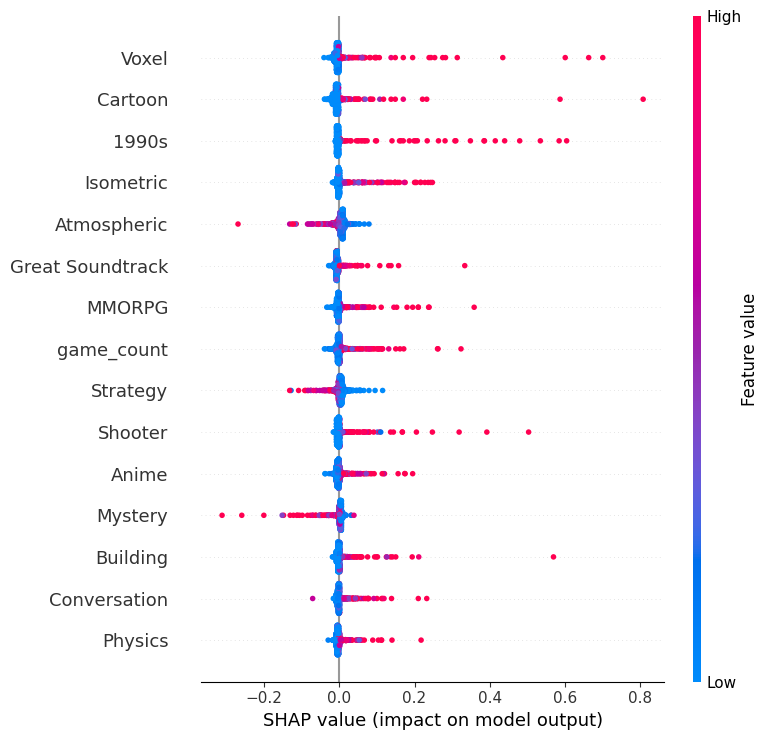

In [104]:
shap.summary_plot(shap_values, test_np, feature_names=df.columns[:-1],max_display=15)

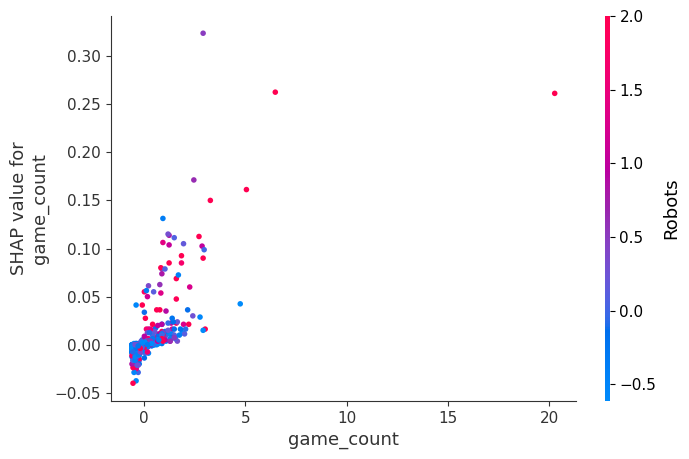

In [105]:
shap.dependence_plot('game_count',shap_values, test_np, feature_names=df.columns[:-1])

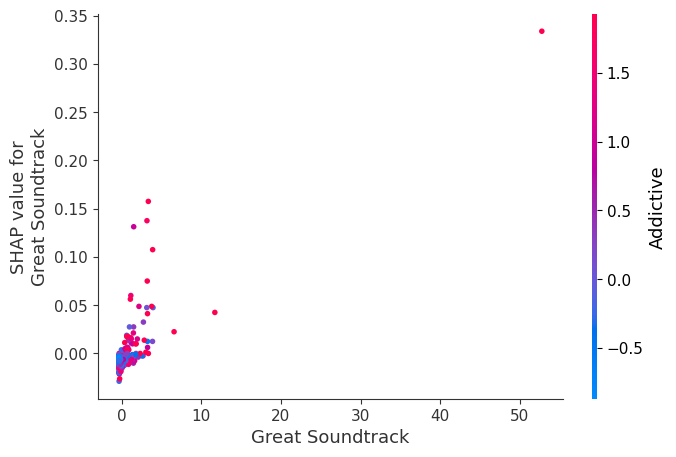

In [106]:
shap.dependence_plot('Great Soundtrack',shap_values, test_np, feature_names=df.columns[:-1])